# Convergence of powerflow

This Notebook gives an insight into how the loadflow converges and what influences it. Original analysis was done by bergkvist (https://github.com/bergkvist) in May 2020, see https://github.com/e2nIEE/pandapower/issues/786.

The resolution is set low, if you are interested in higher resolution please increase the resolution, but do not commit. Since this will slow down the tests tremendously.

In [14]:
import numpy as np
import pandapower as pp
import pandapower.networks as nw
import matplotlib.pyplot as plt
import copy
import warnings

warnings.filterwarnings('ignore')

## Regions of convergence: scaling r and x

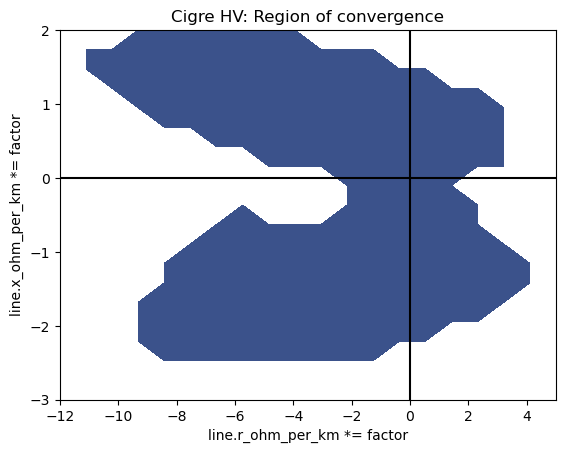

In [85]:
cig = nw.cigre_networks.create_cigre_network_hv()
def convergence_test(r_ohm_factor, x_ohm_factor):
    net = copy.deepcopy(cig)
    net.line.r_ohm_per_km *= r_ohm_factor
    net.line.x_ohm_per_km *= x_ohm_factor
    try:
        pp.runpp(net)
        return 1
    except Exception as e:
        return np.nan

x = np.linspace(-12, 5, 20)
y = np.linspace(-3, 2, 20)
z = np.array([[ convergence_test(xi, yi) for xi in x ] for yi in y ])

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(x, y, z)
ax.set_xlabel('line.r_ohm_per_km *= factor')
ax.set_ylabel('line.x_ohm_per_km *= factor')
ax.set_title('Cigre HV: Region of convergence')
plt.plot([0, 0], [y[0], y[-1]], '-k')
plt.plot([x[0], x[-1]], [0, 0], '-k')

Notice the split in the middle! If x_ohm_per_km is below a threshold for this network, it doesn't matter what value we set for r_ohm_per_km, as it will always diverge.

### Cigre MV

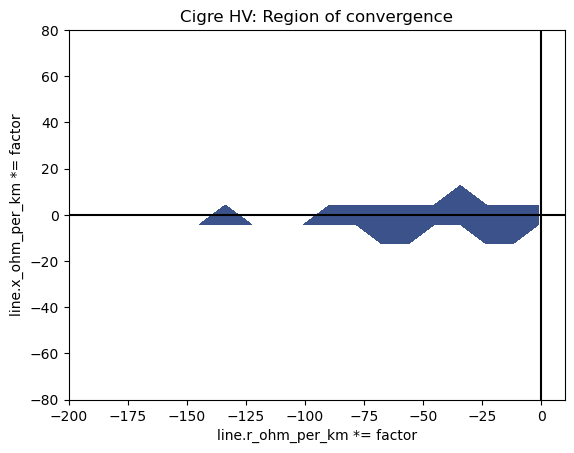

In [9]:
cig = nw.cigre_networks.create_cigre_network_mv()
def convergence_test(r_ohm_factor, x_ohm_factor):
    net = copy.deepcopy(cig)
    net.line.r_ohm_per_km *= r_ohm_factor
    net.line.x_ohm_per_km *= x_ohm_factor
    try:
        pp.runpp(net)
        return 1
    except Exception as e:
        return np.nan

x = np.linspace(-200, 10, 20)
y = np.linspace(-80, 80, 20)
z = np.array([[ convergence_test(xi, yi) for xi in x ] for yi in y ])

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(x, y, z)
ax.set_xlabel('line.r_ohm_per_km *= factor')
ax.set_ylabel('line.x_ohm_per_km *= factor')
ax.set_title('Cigre HV: Region of convergence')
plt.plot([0, 0], [y[0], y[-1]], '-k')
plt.plot([x[0], x[-1]], [0, 0], '-k')

Notice that the region of convergence is a lot larger. In this first image we can't even see the "hole" around the origin.

### Cigre LV

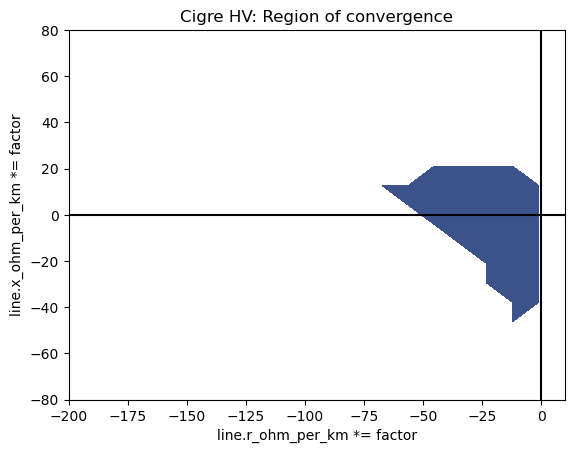

In [10]:
cig = nw.cigre_networks.create_cigre_network_lv()
def convergence_test(r_ohm_factor, x_ohm_factor):
    net = copy.deepcopy(cig)
    net.line.r_ohm_per_km *= r_ohm_factor
    net.line.x_ohm_per_km *= x_ohm_factor
    try:
        pp.runpp(net)
        return 1
    except Exception as e:
        return np.nan

x = np.linspace(-200, 10, 20)
y = np.linspace(-80, 80, 20)
z = np.array([[ convergence_test(xi, yi) for xi in x ] for yi in y ])

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(x, y, z)
ax.set_xlabel('line.r_ohm_per_km *= factor')
ax.set_ylabel('line.x_ohm_per_km *= factor')
ax.set_title('Cigre HV: Region of convergence')
plt.plot([0, 0], [y[0], y[-1]], '-k')
plt.plot([x[0], x[-1]], [0, 0], '-k')

### Observations
- The powerflow calculations will converge for negative r and x-values. The region of convergence also seems to generally be bigger on the negative side for some reason. I have no intuition about what a negative resistance value means.
- It seems like the higher the voltage, the more "sensitive" the network becomes to parameter scaling. (at least impedance).
- Sometimes r or x can be 0 without causing divergence. In the case of Cigre HV, if x_ohm_per_km is below a threshold, it seems to guarantee divergence.

## vk_percent vs vkr_percent

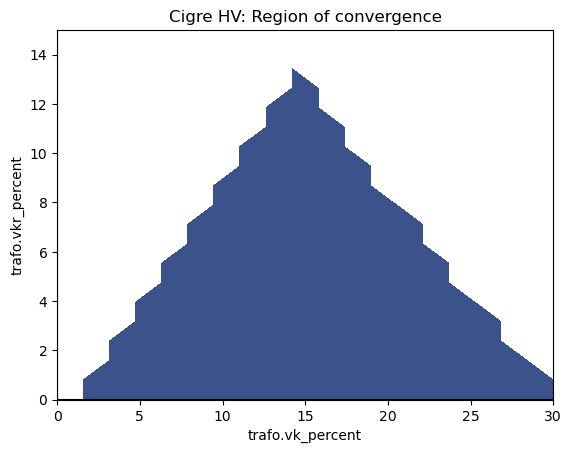

In [87]:
cig = nw.cigre_networks.create_cigre_network_hv()
def convergence_test(vk_percent, vkr_percent):
    net = copy.deepcopy(cig)
    net.trafo.vkr_percent = vkr_percent
    net.trafo.vk_percent = vk_percent
    try:
        pp.runpp(net)
        return 1
    except Exception as e:
        return np.nan

x = np.linspace(0, 30, 20)
y = np.linspace(0, 15, 20)
z = np.array([[ convergence_test(xi, yi) for xi in x ] for yi in y ])

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(x, y, z)
ax.set_xlabel('trafo.vk_percent')
ax.set_ylabel('trafo.vkr_percent')
ax.set_title('Cigre HV: Region of convergence')
plt.plot([0, 0], [y[0], y[-1]], '-k')
plt.plot([x[0], x[-1]], [0, 0], '-k')

Seems a bit more well behaved than the impedance-ROCs. If this is actually a perfect triangle, then maybe we could predict based on vkr_percent and vk_percent values whether the powerflow will diverge.

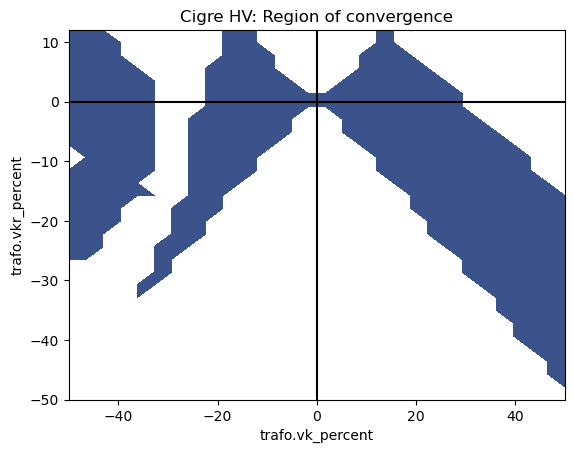

In [16]:
cig = nw.cigre_networks.create_cigre_network_hv()
def convergence_test(vk_percent, vkr_percent):
    net = copy.deepcopy(cig)
    net.trafo.vkr_percent = vkr_percent
    net.trafo.vk_percent = vk_percent
    try:
        pp.runpp(net)
        return 1
    except Exception as e:
        return np.nan

x = np.linspace(-50, 50, 30)
y = np.linspace(-50, 12, 30)
z = np.array([[ convergence_test(xi, yi) for xi in x ] for yi in y ])

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(x, y, z)
ax.set_xlabel('trafo.vk_percent')
ax.set_ylabel('trafo.vkr_percent')
ax.set_title('Cigre HV: Region of convergence')
plt.plot([0, 0], [y[0], y[-1]], '-k')
plt.plot([x[0], x[-1]], [0, 0], '-k')

### Exploring vk_percent and vkr_percent convergence a bit more

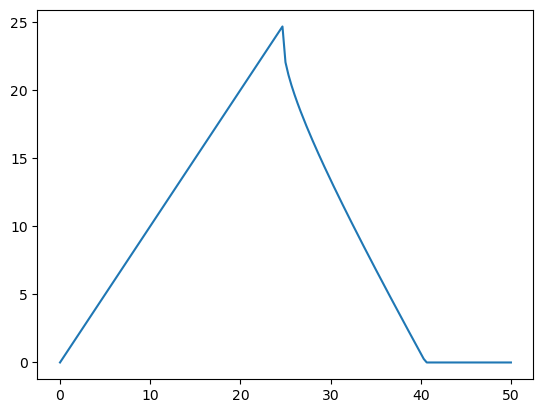

In [19]:
cig = nw.cigre_networks.create_cigre_network_mv()

def convergence_test(vk_percent, vkr_percent):
    net = copy.deepcopy(cig) # Deepcopy is much faster than loading the network again
    net.trafo.vk_percent = vk_percent
    net.trafo.vkr_percent = vkr_percent
    try:
        pp.runpp(net)
        return 1
    except Exception as e:
        return np.nan

# Binary search to find the limit between convergence and divergence for vkr_percent
def find_vkr_percent_limit(vk_percent, vkr_conv, vkr_div, tolerance=1e-3):
    if abs(vkr_div - vkr_conv) < tolerance: return vkr_conv
    vkr_test = 0.5 * (vkr_div + vkr_conv)
    if np.isnan(convergence_test(vk_percent, vkr_test)):
        return find_vkr_percent_limit(vk_percent, vkr_conv, vkr_test, tolerance)
    else:
        return find_vkr_percent_limit(vk_percent, vkr_test, vkr_div, tolerance)

# Assuming vkr_percent=0 converges, vk_percent=40 diverges, the limits will be found:
vk_percent = np.linspace(0, 50, 151)
vkr_percent = np.vectorize(find_vkr_percent_limit)(vk_percent, vkr_conv=0.0, vkr_div=40.0)
plt.plot(vk_percent, vkr_percent)

Notice that up to some value for vk_percent, 0 <= vkr_percent <= vk_percent will cause converge. But we do actually get divergence here when vkr_percent > vk_percent.

The trailing 0s in the end of the plot means that no solution between 0 and 40 was found.

## As for c_nf_per_km, and the effect of scaling the voltage

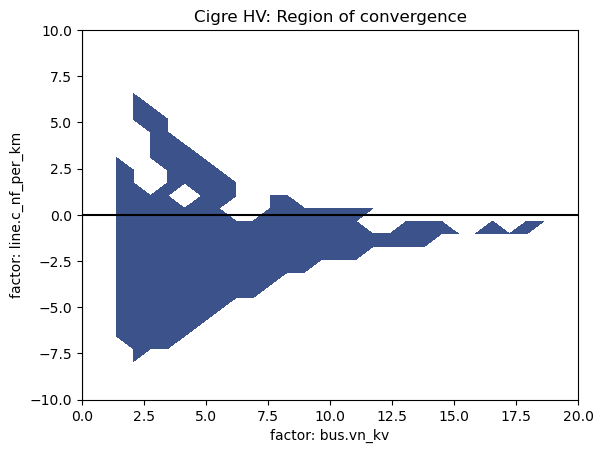

In [18]:
cig = nw.cigre_networks.create_cigre_network_hv()
def convergence_test(vn_kv_factor, c_nf_factor):
    net = copy.deepcopy(cig)
    net.bus.vn_kv *= vn_kv_factor
    net.trafo.vn_hv_kv *= vn_kv_factor
    net.trafo.vn_lv_kv *= vn_kv_factor
    net.shunt.vn_kv *= vn_kv_factor
    net.line.c_nf_per_km *= c_nf_factor
    try:
        pp.runpp(net)
        return 1
    except Exception as e:
        return np.nan

x = np.linspace(0, 20, 30)
y = np.linspace(-10, 10, 30)
z = np.array([[ convergence_test(xi, yi) for xi in x ] for yi in y ])

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(x, y, z)
ax.set_xlabel('factor: bus.vn_kv')
ax.set_ylabel('factor: line.c_nf_per_km')
ax.set_title('Cigre HV: Region of convergence')
plt.plot([0, 0], [y[0], y[-1]], '-k')
plt.plot([x[0], x[-1]], [0, 0], '-k')

These regions of convergence look surprisingly weird/interesting.

## Some more analysis on r_ohm and x_ohm-scaling

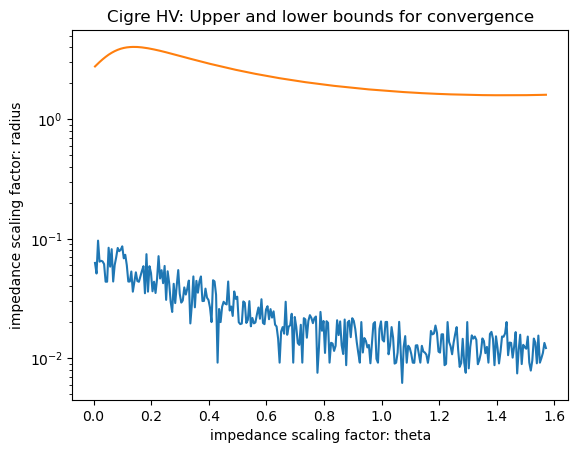

In [21]:
def from_polar(r, th):
    return r * np.cos(th), r * np.sin(th)

@np.vectorize
def limit_polar_log_search(test_fn, theta, log_radius_conv, log_radius_div,
                           tolerance=1e-3, max_iterations=50):
    # Check that radius_conv does not cause divergence
    if np.isnan(test_fn(*from_polar(np.exp(log_radius_conv), theta))):
        return np.nan

    # Check that radius_div does not cause convergence
    if test_fn(*from_polar(np.exp(log_radius_div), theta)) == 1:
        return np.nan

    while (np.abs(log_radius_div - log_radius_conv) > tolerance
           and max_iterations > 0):
        max_iterations -= 1
        log_radius_test = (log_radius_div + log_radius_conv) / 2
        if np.isnan(test_fn(*from_polar(np.exp(log_radius_test), theta))):
            log_radius_div = log_radius_test
        else:
            log_radius_conv = log_radius_test

    return np.exp(log_radius_conv)

cig = nw.cigre_networks.create_cigre_network_hv()
def convergence_test(r_ohm_factor, x_ohm_factor):
    net = copy.deepcopy(cig) # Deepcopy is much faster than loading the network again
    net.line.r_ohm_per_km *= r_ohm_factor
    net.line.x_ohm_per_km *= x_ohm_factor
    try:
        pp.runpp(net)
        return 1
    except Exception as e:
        return np.nan

theta = np.linspace(0, np.pi/2, 50)
radius_upper = limit_polar_log_search(convergence_test, theta, log_radius_conv=0, log_radius_div=50)
radius_lower = limit_polar_log_search(convergence_test, theta, log_radius_conv=0, log_radius_div=-50)

fig, ax = plt.subplots(1, 1)
ax.plot(theta, radius_lower)
ax.plot(theta, radius_upper)
ax.set_xlabel('impedance scaling factor: theta')
ax.set_ylabel('impedance scaling factor: radius')
ax.set_title('Cigre HV: Upper and lower bounds for convergence')
ax.set_yscale('log')

### Observations
- Now we are able to see the upper and lower limits in a single visualization. This is able to tell us something about how robust our values for r_ohm and x_ohm are. Essentially: how safe is it to scale them up or down.
- As we saw in the previous 2D-ROC-plot, a small angle will guarantee divergence for Cigre HV. This is kind of hard to notice in the plot (where nan-values are not shown). This should probably be highlighted in some kind of way.
- This is a lot more efficient than the 2D-ROC-pixel-plots for finding upper and lower bounds with high accuracy.
- The slope of the upper bound tells us whether the network is more resilient to r_ohm increasing or x_ohm increasing. Maybe this can tell us something interesting about the network.
- The lower bound is very "uneven" while the upper bound seems smooth. The upper and lower bounds seem to have a slope in the same direction.

## Voltage stability

ext_grid(1pu) <--> bus(10kV) <--> line <--> bus(10kV) <--> load(1MW)

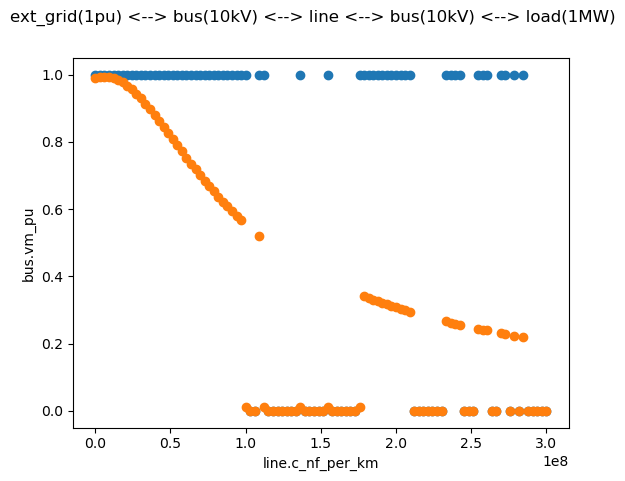

In [93]:
net = pp.create_empty_network()
b1 = pp.create_bus(net, vn_kv=10.0, name='b1')
b2 = pp.create_bus(net, vn_kv=10.0, name='b2')
pp.create_load(net, bus=b2, p_mw=1.)
pp.create_ext_grid(net, bus=b1, vm_pu=1.0)
pp.create_line_from_parameters(net, from_bus=b1, to_bus=b2, length_km=1,
                                   r_ohm_per_km=1, x_ohm_per_km=0.1,
                                   c_nf_per_km=0.1, max_i_ka=10)

def convergence_test(c_nf_factor):
    nt = copy.deepcopy(net)
    nt.line.c_nf_per_km *= c_nf_factor
    try:
        pp.runpp(nt)
        return nt.res_bus.vm_pu
    except Exception as e:
        return np.array([0., 0.])

x = np.linspace(1e4, 3e8, 100)
z = np.array([ convergence_test(xi) for xi in x ])

fig = plt.figure()
plt.xlabel('line.c_nf_per_km')
plt.ylabel('bus.vm_pu')
fig.suptitle('ext_grid(1pu) <--> bus(10kV) <--> line <--> bus(10kV) <--> load(1MW)')
plt.plot(x, z, 'o')
plt.show()

### Observations
- The blue line represents the bus connected to the slack bus, so it makes sense that the voltage here remains constant. Notice the "holes" in this line, however - showing where the powerflow diverges.
- The orange line represents the load bus, at the other end of the line. The voltage starts rising, before diverging randomly and fluctuating between ~0.2 and 1.0-1.05.
- Since Netwton-Rhapson can only converge to a single solution, maybe this means we actually have 2 solutions here, and it is unpredictable which one we will converge to? And one could guess this region might also be highly unlinear, meaning the solution can easily diverge by hitting a bump on the way to a solution.
- Based on the 2D-ROC plots we have seen that the ROC sometimes seem to become fractal-like at the border (although in some places it is actually very smooth).

### Questions
- Does the situation with vm_pu = 0.2 in the result correspond to a "voltage collapse", like those that have caused several major power grid blackouts?
- When there are multiple solutions, how would reality "pick one of them"?
    My guess is that both would be valid steady-states of the grid in reality. But in this region the network would be extremely sensitive to disturbances - that could throw it into a voltage-collapsed state.
- Why does it seem like there is a continuous transition to the collapsed state?

## Divergence doesn't neccesarily correspond to voltage collapse!

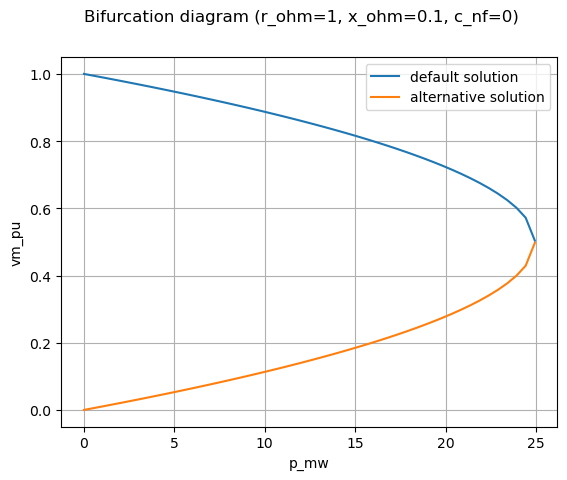

In [25]:
def binary_search(fn, x_ok, x_err, tolerance=1e-6, max_iterations=20):
    def try_fn(x):
        try:
            fn(x)
            return 1
        except:
            return 0

    assert try_fn(x_ok) == 1
    assert try_fn(x_err) == 0

    while abs(x_err - x_ok) > tolerance and max_iterations > 0:
        x_guess = (x_ok + x_err) / 2
        if try_fn(x_guess) == 0:
            x_err = x_guess
        else:
            x_ok = x_guess
        max_iterations -= 1

    return x_ok

def create_network(p_mw):
    net = pp.create_empty_network()
    b0, b1 = pp.create_buses(net, nr_buses=2, vn_kv=10)
    pp.create_ext_grid(net, bus=b0, vm_pu=1)
    pp.create_line_from_parameters(net, from_bus=b0, to_bus=b1, length_km=1,
                                   r_ohm_per_km=1, x_ohm_per_km=0.1,
                                   c_nf_per_km=0, max_i_ka=10)
    pp.create_load(net, bus=b1, p_mw=p_mw)
    return net

@np.vectorize
def find_voltage(p_mw, vm_pu_init):
    net = create_network(p_mw)
    try:
        pp.runpp(net, init_vm_pu=[1, vm_pu_init])
        return net.res_bus.iloc[1].vm_pu
    except:
        return np.nan

# Find the maximum value for p_mw where the network converges
p_mw_max = binary_search(lambda p_mw: pp.runpp(create_network(p_mw), init='flat'), 0, 50)

# Show that in there are two different solutions for every converging p_mw
p_mw = np.linspace(0, p_mw_max, 50)
vm_pu_high = find_voltage(p_mw, vm_pu_init=1)
vm_pu_low = find_voltage(p_mw, vm_pu_init=0.1)

fig = plt.figure()
fig.suptitle('Bifurcation diagram (r_ohm=1, x_ohm=0.1, c_nf=0)')
plt.plot(p_mw, vm_pu_high)
plt.plot(p_mw, vm_pu_low)
plt.xlabel('p_mw')
plt.ylabel('vm_pu')
plt.legend(['default solution','alternative solution'])
plt.grid(True)
plt.show()

Divergence is caused by trying to use more power than the maximum power transfer theorem allows.
https://en.wikipedia.org/wiki/Maximum_power_transfer_theorem

The two solutions simply correspond to the two possible load impedances that yield the same power consumption.

## Setting c_nf_per_km to a high value (1e7)

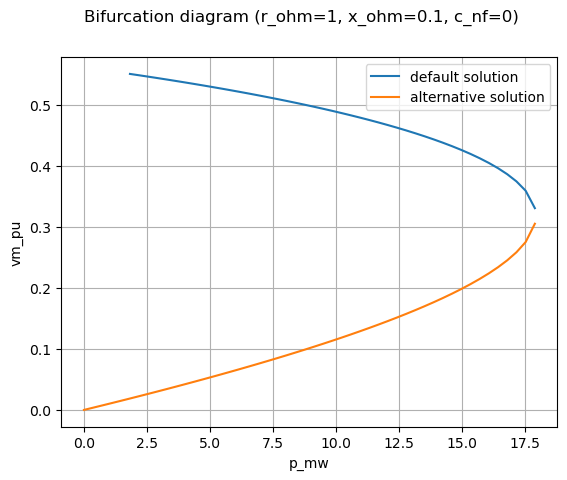

In [26]:
def binary_search(fn, x_ok, x_err, tolerance=1e-6, max_iterations=20):
    def try_fn(x):
        try:
            fn(x)
            return 1
        except:
            return 0

    assert try_fn(x_ok) == 1
    assert try_fn(x_err) == 0

    while abs(x_err - x_ok) > tolerance and max_iterations > 0:
        x_guess = (x_ok + x_err) / 2
        if try_fn(x_guess) == 0:
            x_err = x_guess
        else:
            x_ok = x_guess
        max_iterations -= 1

    return x_ok

def create_network(p_mw):
    net = pp.create_empty_network()
    b0, b1 = pp.create_buses(net, nr_buses=2, vn_kv=10)
    pp.create_ext_grid(net, bus=b0, vm_pu=1)
    pp.create_line_from_parameters(net, from_bus=b0, to_bus=b1, length_km=1,
                                   r_ohm_per_km=1, x_ohm_per_km=0.1,
                                   c_nf_per_km=1e7, max_i_ka=10)
    pp.create_load(net, bus=b1, p_mw=p_mw)
    return net

@np.vectorize
def find_voltage(p_mw, vm_pu_init):
    net = create_network(p_mw)
    try:
        pp.runpp(net, init_vm_pu=[1, vm_pu_init])
        return net.res_bus.iloc[1].vm_pu
    except:
        return np.nan

# Find the maximum value for p_mw where the network converges
p_mw_max = binary_search(lambda p_mw: pp.runpp(create_network(p_mw), init='flat'), 0, 50)

# Show that in there are two different solutions for every converging p_mw
p_mw = np.linspace(0, p_mw_max, 50)
vm_pu_high = find_voltage(p_mw, vm_pu_init=1)
vm_pu_low = find_voltage(p_mw, vm_pu_init=0.1)

fig = plt.figure()
fig.suptitle('Bifurcation diagram (r_ohm=1, x_ohm=0.1, c_nf=1e7)')
plt.plot(p_mw, vm_pu_high)
plt.plot(p_mw, vm_pu_low)
plt.xlabel('p_mw')
plt.ylabel('vm_pu')
plt.legend(['default solution','alternative solution'])
plt.grid(True)
plt.show()

Some things to notice here:

- Maximum power transfer at vm_pu ~0.3, p_mw ~17.5 MW
- The diagram is not symmetric. The lower part is now taller than the upper part.
- Low voltage (alternative) solutions suffer from numerical instability. (the alternative solution corresponds to the load impedance being close to 0)


## Setting x_ohm = 3 * r_ohm

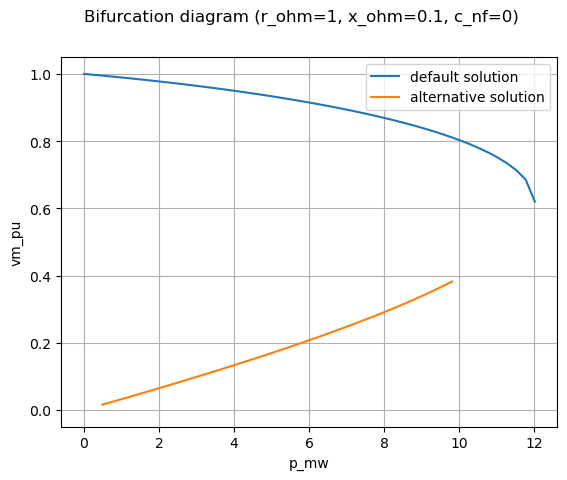

In [27]:
def binary_search(fn, x_ok, x_err, tolerance=1e-6, max_iterations=20):
    def try_fn(x):
        try:
            fn(x)
            return 1
        except:
            return 0

    assert try_fn(x_ok) == 1
    assert try_fn(x_err) == 0

    while abs(x_err - x_ok) > tolerance and max_iterations > 0:
        x_guess = (x_ok + x_err) / 2
        if try_fn(x_guess) == 0:
            x_err = x_guess
        else:
            x_ok = x_guess
        max_iterations -= 1

    return x_ok

def create_network(p_mw):
    net = pp.create_empty_network()
    b0, b1 = pp.create_buses(net, nr_buses=2, vn_kv=10)
    pp.create_ext_grid(net, bus=b0, vm_pu=1)
    pp.create_line_from_parameters(net, from_bus=b0, to_bus=b1, length_km=1,
                                   r_ohm_per_km=1, x_ohm_per_km=3,
                                   c_nf_per_km=0, max_i_ka=10)
    pp.create_load(net, bus=b1, p_mw=p_mw)
    return net

@np.vectorize
def find_voltage(p_mw, vm_pu_init):
    net = create_network(p_mw)
    try:
        pp.runpp(net, init_vm_pu=[1, vm_pu_init])
        return net.res_bus.iloc[1].vm_pu
    except:
        return np.nan

# Find the maximum value for p_mw where the network converges
p_mw_max = binary_search(lambda p_mw: pp.runpp(create_network(p_mw), init='flat'), 0, 50)

# Show that in there are two different solutions for every converging p_mw
p_mw = np.linspace(0, p_mw_max, 50)
vm_pu_high = find_voltage(p_mw, vm_pu_init=1)
vm_pu_low = find_voltage(p_mw, vm_pu_init=0.1)

fig = plt.figure()
fig.suptitle('Bifurcation diagram (r_ohm=1, x_ohm=3, c_nf=0)')
plt.plot(p_mw, vm_pu_high)
plt.plot(p_mw, vm_pu_low)
plt.xlabel('p_mw')
plt.ylabel('vm_pu')
plt.legend(['default solution','alternative solution'])
plt.grid(True)
plt.show()

- Maximum power transfer at vm_pu ~0.6, p_mw ~12MW
- The diagram is not symmetric.
- Low voltage (alternative) solutions suffer from numerical instability.

## Purely reactive line impedance

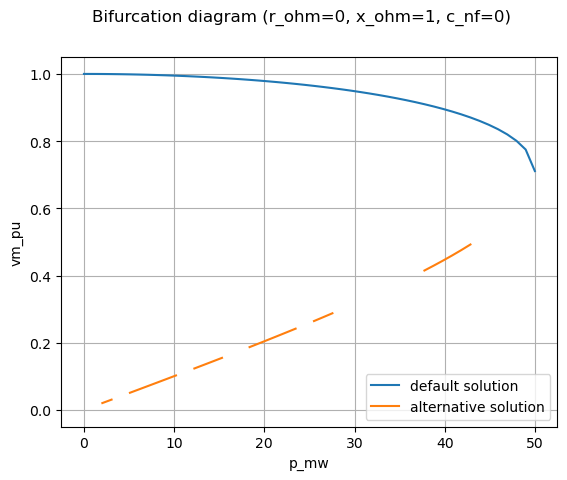

In [28]:
def binary_search(fn, x_ok, x_err, tolerance=1e-6, max_iterations=20):
    def try_fn(x):
        try:
            fn(x)
            return 1
        except:
            return 0

    assert try_fn(x_ok) == 1
    assert try_fn(x_err) == 0

    while abs(x_err - x_ok) > tolerance and max_iterations > 0:
        x_guess = (x_ok + x_err) / 2
        if try_fn(x_guess) == 0:
            x_err = x_guess
        else:
            x_ok = x_guess
        max_iterations -= 1

    return x_ok

def create_network(p_mw):
    net = pp.create_empty_network()
    b0, b1 = pp.create_buses(net, nr_buses=2, vn_kv=10)
    pp.create_ext_grid(net, bus=b0, vm_pu=1)
    pp.create_line_from_parameters(net, from_bus=b0, to_bus=b1, length_km=1,
                                   r_ohm_per_km=0, x_ohm_per_km=1,
                                   c_nf_per_km=0, max_i_ka=10)
    pp.create_load(net, bus=b1, p_mw=p_mw)
    return net

@np.vectorize
def find_voltage(p_mw, vm_pu_init):
    net = create_network(p_mw)
    try:
        pp.runpp(net, init_vm_pu=[1, vm_pu_init])
        return net.res_bus.iloc[1].vm_pu
    except:
        return np.nan

# Find the maximum value for p_mw where the network converges
p_mw_max = binary_search(lambda p_mw: pp.runpp(create_network(p_mw), init='flat'), 0, 50)

# Show that in there are two different solutions for every converging p_mw
p_mw = np.linspace(0, p_mw_max, 50)
vm_pu_high = find_voltage(p_mw, vm_pu_init=1)
vm_pu_low = find_voltage(p_mw, vm_pu_init=0.1)

fig = plt.figure()
fig.suptitle('Bifurcation diagram (r_ohm=0, x_ohm=1, c_nf=0)')
plt.plot(p_mw, vm_pu_high)
plt.plot(p_mw, vm_pu_low)
plt.xlabel('p_mw')
plt.ylabel('vm_pu')
plt.legend(['default solution','alternative solution'])
plt.grid(True)
plt.show()

- Maximum power transfer at vm_pu ~0.7, p_mw ~50MW
- The diagram is not symmetric.
- Low voltage (alternative) solutions suffer from numerical instability.